In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import numpy as np
from simulator import AnalogCore
from simulator import CrossSimParameters
from simulator.devices import idevice
import scipy.linalg
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(198)

### Part 3: Adding custom device models

CrossSim provides an easy-to-use and highly flexible interface for defining custom device behavioral models, which can then be called by AnalogCore.

First, we will define the matrix and the problem. Once again, we'll use the 2D DFT example.

In [2]:
# DFT matrix
N_ft1, N_ft2 = 128, 128
W_dft = scipy.linalg.dft(N_ft1)
W_idft = np.matrix.getH(W_dft)

# Load image and resize
Nch = 3
X_flower = Image.open('../applications/dsp/example_images/peppers.jpg').resize((N_ft1,N_ft2))
X_flower = np.array(X_flower).astype(np.float32) / 255

Let's define a custom device class. For now, just to illustrate the structure of the interface, the custom model will simply implement a perfect device.

In [3]:
class perfect_device(idevice.EmptyDevice):
    
    #### Programming error model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # when the core is initialized
    def programming_error(self, Gnorm):
        return Gnorm
    
    #### Read noise model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # every time an MVM or VMM is called
    def read_noise(self, Gnorm):
        return Gnorm

    #### Drift model
    # Error is applied to the normalized conductance matrix Gnorm that 
    # depends on a time parameter
    def drift_error(self, Gnorm, time):
        return Gnorm

Now, set the parameters:

In [4]:
# Set parameters
params = CrossSimParameters()
params.core.complex_matrix = True
params.core.complex_inputs = True
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = True
params.xbar.device.drift_error.enable = True
params.xbar.device.time = 0 # units: days
params.xbar.device.read_noise.model = "perfect_device"
params.xbar.device.programming_error.model = "perfect_device"
params.xbar.device.drift_error.model = "perfect_device"

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft, params=params)
xbar_idft = AnalogCore(W_idft, params=params)

Now, perform the computation:

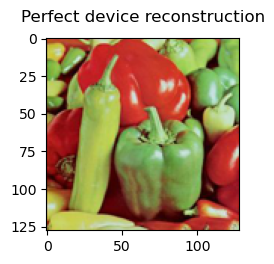

In [5]:
# Perform image reconstruction
X_recon = np.zeros(X_flower.shape, dtype=np.complex128)
for ch in range(Nch):
    Y_ch = (xbar_dft @ X_flower[:,:,ch]) @ xbar_dft
    X_recon[:,:,ch] = (xbar_idft @ Y_ch) @ xbar_idft        
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.imshow(X_recon)
ax.set_title("Perfect device reconstruction", y=1.04)
plt.show()

Now, let's define a more interesting hypothetical device. We'll call it "fictional_flash".
- __Programming error__ is a random normal whose standard deviation depends on conductance: $$\sigma_W(G) = B\left(1 - \exp\left(-AG\right)\right)$$
where $G$ is in nanoSiemens, $A$ = 0.0002/nS and $B$ = 3000 nS. This describes an error that is zero at zero conductance and saturates to 3000 nS at  high conductance.
<br />
- __Read noise__ is a random normal whose standard deviation increases quadratically with $G$: $$\frac{\sigma_R(G)}{G_\text{max}} = 0.2 \left(\frac{G}{G_\text{max}}\right)^2$$
<br />

- __Drift error__ is a simple exponential decay with time: $$ G(t) = G(0) \exp\left(-t/t_0\right)$$ The characteristic decay time $t_0$ varies randomly from device to device, following a normal distribution with mean of 10 days and a standard deviation of 2 days.

In [6]:
class fictional_flash(idevice.EmptyDevice):
    
    #### Programming error model
    def programming_error(self, Gnorm):
        # Convert the normalized conductance matrix into nanoSiemens
        Gmax = 1/self.device_params.Rmin
        G = Gnorm * Gmax * 1e9
        
        # Compute the sigma of the noise to be applied to each element, then
        # apply the random errors to G
        sigma_W = 3000*(1 - np.exp(-0.0002*G))
        G += np.random.normal(loc=0.0, scale=sigma_W, size=G.shape)
        
        # Scale the conductance back down to normalized conductance units
        Gnorm = G * 1e-9 / Gmax
        return Gnorm
    
    #### Read noise model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # every time an MVM or VMM is called
    def read_noise(self, Gnorm):
        sigma_R = 0.2*Gnorm**2
        Gnorm += np.random.normal(loc=0.0, scale=sigma_R, size=Gnorm.shape)
        return Gnorm

    #### Drift model
    # Error is applied to the normalized conductance matrix Gnorm that 
    # depends on a time parameter
    def drift_error(self, Gnorm, time):
        t0 = np.random.normal(loc = 10, scale = 2, size=Gnorm.shape)
        t0 = np.maximum(t0, 1)
        return Gnorm * np.exp(-time/t0)


First, let's look at the effect of programming error alone:

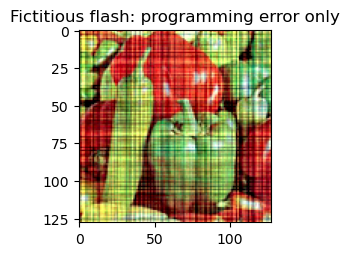

In [7]:
params = CrossSimParameters()

# Core level parameters
params.core.style = "BALANCED"
params.core.complex_matrix = True
params.core.complex_inputs = True
params.core.mapping.inputs.mvm.min = 0
params.core.mapping.inputs.mvm.max = 1

# Device level parameters
params.xbar.device.cell_bits = 7 # target G resolution
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.read_noise.model = "fictional_flash"
params.xbar.device.programming_error.model = "fictional_flash"
params.xbar.device.drift_error.model = "fictional_flash"
params.xbar.device.time = 0
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = False
# clip_conductance = False allows perturbed resistance to fall outside Rmin, Rmax bounds
params.xbar.device.clip_conductance = False

# AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft, params=params)
xbar_idft = AnalogCore(W_idft, params=params)

# Perform image reconstruction
X_recon = np.zeros((N_ft1,N_ft2,Nch), dtype=np.complex128)
for ch in range(Nch):
    Y_ch = (xbar_dft @ X_flower[:,:,ch]) @ xbar_dft
    X_recon[:,:,ch] = (xbar_idft @ Y_ch) @ xbar_idft        
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,ax = plt.subplots(1,1,figsize=(3.5,2.5))
ax.imshow(X_recon[:,:,:])
ax.set_title("Fictitious flash: programming error only")
plt.show()

Next, let's turn on both programming error and read noise. After programming, we perform the image reconstruction 6 times to see the random effect of read noise. In this example, the read noise effect shows up as somewhat subtle differences in the artifacts that appear in the image from run to run.

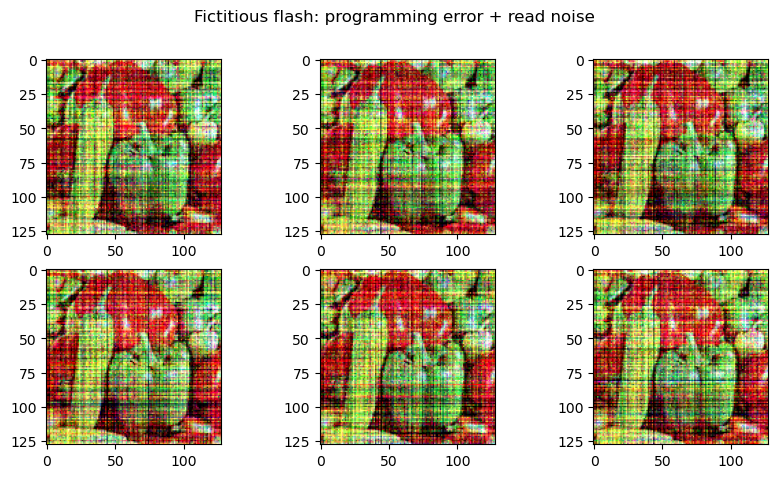

In [8]:
params.xbar.device.time = 0
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = True
params.xbar.device.drift_error.enable = False

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft, params=params)
xbar_idft = AnalogCore(W_idft, params=params)

# Perform image reconstruction
Nruns = 6
X_recon = np.zeros((N_ft1,N_ft2,Nch,Nruns), dtype=np.complex128)
for run in range(Nruns):
    for ch in range(Nch):
        Y_ch = (xbar_dft @ X_flower[:,:,ch]) @ xbar_dft
        X_recon[:,:,ch,run] = (xbar_idft @ Y_ch) @ xbar_idft        
        
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,5))
run = 0
fig.suptitle("Fictitious flash: programming error + read noise")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.imshow(X_recon[:,:,:,run])
    run += 1
plt.show()

Finally, let's look at how the image reconstruction gets worse over time:

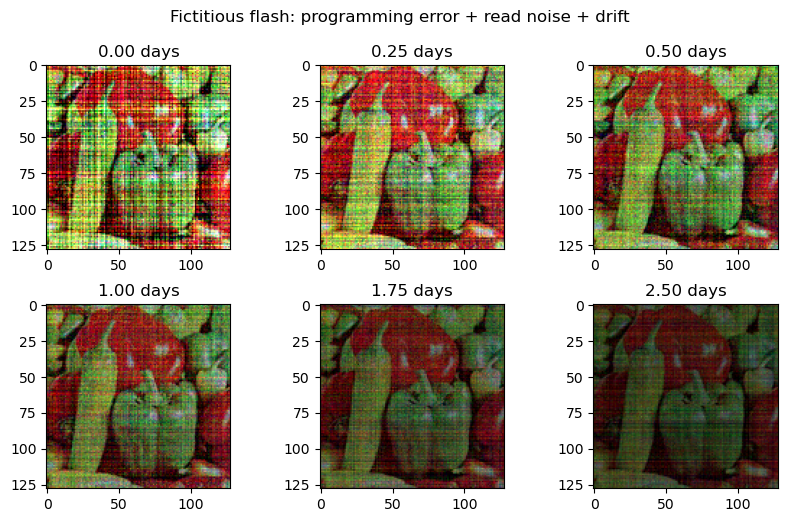

In [9]:
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = True
params.xbar.device.drift_error.enable = True

times = np.array([0, 0.25, 0.5, 1, 1.75, 2.5])
X_recon = np.zeros((N_ft1,N_ft2,Nch,len(times)), dtype=np.complex128)

for k in range(len(times)):
    params.xbar.device.time = times[k]
    
    # AnalogCores and program matrix
    xbar_dft = AnalogCore(W_dft, params=params)
    xbar_idft = AnalogCore(W_idft, params=params)

    # Perform image reconstruction
    for ch in range(Nch):
        Y_ch = (xbar_dft @ X_flower[:,:,ch]) @ xbar_dft
        X_recon[:,:,ch,k] = (xbar_idft @ Y_ch) @ xbar_idft
        
X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

# Show reconstructed image
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,5.5))
plt.subplots_adjust(hspace=0.3)
k = 0
fig.suptitle("Fictitious flash: programming error + read noise + drift")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.imshow(X_recon[:,:,:,k])
    ax.set_title("{:.2f} days".format(times[k]))
    k += 1
plt.show()

Over time, the reconstructed image becomes darker. This is expected, since the conductance values are decaying exponentially with time, so the analog MVM signal is getting weaker as well.